# Lab 2: Methods in Linear Regression

In this lab we will canvas various techniques in linear regression analysis and apply them to the numerical variable in the Ames dataset. Some of the techniques, like Ridge Regression and Lasso Regression are already implemented in sci-kit learn, or statsmodels.api but some, like best subset regression, are not. 

In this lab, we'll be looking at __Linear Regression__, __Best Subset Selection__, __Forward Subset regression__, __Ridge Regression__ and __Lasso Regreesion__. We will be comparing these models using the number of degrees of freedom. We will be benchmarking these techniques using cross validation, that is by splitting our data into a training set and a test set and comparing the score on the test set. 

We will use two libraries in this lab: Sci-kit Learn and Statsmodel.api. Both have their uses and often implement similar functionality. The main difference is that Statsmodel.api is designed around statical computing, giving rich, human readable feedback the way the R might but at the cost that different functions behave differently. 

On the other hand, Sci-kit Learn is trying to implement a unified way of training and using any machine learning model. That is the syntax is the same for linear model, quadratic models, clusters, $k$-NN, etc. For example, for any Sci-kit model, `model.fit(X,Y)` will train the model on the data `X` with labels `Y` and `model.score(XT,YT)` will score the model on test data. 

We will discuss both libraries in this lab. 

#### Getting back to where we were

Lets quickly download the Ames dataset and throw out the outliers recomended in the documentation. Recall

<div class="alert alert-block alert-info">
SPECIAL NOTES:<br>
There are 5 observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will indicate them quickly). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these 5 unusual observations) before assigning it to students.<br><br>

http://jse.amstat.org/v19n3/decock/DataDocumentation.txt
</div>

Lets load in our standard libraries and dataset:

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import io
import requests

# If there is a problem loading the data, download the data file first. 
url = "https://raw.githubusercontent.com/tipthederiver/Math-7243-2020/master/Datasets/Ames/train.csv"
s = requests.get(url).content
ames = pd.read_csv(io.StringIO(s.decode('utf-8')))
ames

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


Our first job is to clean the outlier mentioned in the documentation for the Ames dataset. We will follow their suggestion and remove all houses over 4000 square feet of above ground living area.

In [2]:
z = ames['GrLivArea']+ames['BsmtUnfSF']<4000
print("Number of records removed:",len(ames) - sum(z))
data = ames[z]

Number of records removed: 24


Indeed, we can check quickly and see that this removes our weird outliers from before.

Text(0.5, 1.0, 'Cleaned Data')

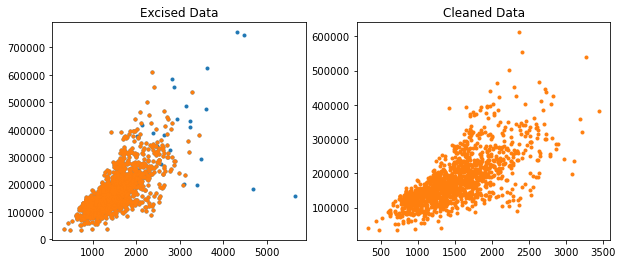

In [3]:
f, axes = plt.subplots(1,2)
f.set_size_inches(10,4)

axes[0].plot(ames['GrLivArea'],ames['SalePrice'],'.')
axes[0].plot(data['GrLivArea'],data['SalePrice'],'.')
axes[1].plot(data['GrLivArea'],data['SalePrice'],'.',color="C1")

axes[0].set_title("Excised Data")
axes[1].set_title("Cleaned Data")

#### Removing catagorical varaibles

The next step is to cut out all of the catagorical varaibles. There are ways to use regression to fit cataogrical variables but we will not be focusing on those methods in this lab. As before we will do this using the `DataFrame.include` function and only including the numerical data types `int64` and `float64`.

In [4]:
data = data.select_dtypes(include=['int64','float64'])
display(data.head(5))

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


It is worth going through the documentation and checking if any of the variables that are represented numerically in the dataframe actually represent categorical variables (like error codes, phone number prefixes, etc).  In fact, the documentation tells us that __MSSubClass__ is a categorical variable, with each number representing a zoning code. We should drop it using `DataFrame.drop()`.

* `DataFrame.drop(columns=[name1,name2,...])` drops a list of column by name. It then returns the new dataframe which must be saved into a variable. `drop` can also be used to drop rows. 

In addition, __ID__ is just a label and could be dropped. It should be noted that the ML school of thought would say we should consider _not_ dropping these indices. The idea is very much "throw in all the data, maybe there's some correlation there we don't see." We will drop the data for this lab just for practice.  

In [5]:
data = data.drop(columns='MSSubClass')
data.head(5)

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,2,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,3,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,4,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,5,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


## Cross validation

We want to measure how well a classifier will work on unseen data. To that end, we usually split our data into two pieces, a __training set__ that we will use to train the regression function, and a __test set__ that we will use to evaluate the function. This method sacrifices some of our data to (hopefully) increase our accuracy by giving  to get a better idea of how good our fit actually. If overfitting is a concern, it is vital to test a regression function against data that is was not trained on. Typically in Machine Learning, we will test many models with the train test split and use their relative accuracies to determine which model should be used for that particular problem. The model can then be trained against to entire dataset before being put into production.

We will use a 80%-20% train-test split. Since we have 1449 data points, the training set will be 1159 rows and the test set will be 290 rows. We can use Pandas built in `df.sample` function to sample the dataframe and the drop the training rows the form the test set.

* `DataFrame.sample(n=None, frac=None, replace=True, random_state=None)` Sample elements of a dataframe. If `n` is specified it returns a number of elements from the dataframe, if `frac` is specified it returns a fraction of the dataframe. The `replace` determines whether the sampling is done with or without replacement. It can be set to `False` but defaults to `True`. The `random_state` parameter is a random seed.  

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html

In [7]:
print("Train Size:", 1449*.8)
print("Test Size:", 1449*.2)

Train Size: 1159.2
Test Size: 289.8


In [6]:
Test_Size = 1159

train=data.sample(n=Test_Size,replace=False,random_state=150)
test=data.drop(train.index)

print("Train Shape", train.shape)
print("Test Shape", test.shape)

Train Shape (1159, 37)
Test Shape (277, 37)


We then split the train and test into input and target data.

In [7]:
X_train = train.drop(columns=['SalePrice','Id'])
Y_train = train['SalePrice']

X_test = test.drop(columns=['SalePrice','Id'])
Y_test = test['SalePrice']

## Linear Regression

We now want to perform our first predictions using linear regression. We will do a quick one variable fit, only fitting the feature __1stFlrSF__ using both linear algebra and then using the sci-kit learn library and compare the fits. 

For a single feature, we want to fit a 2 vector of constants $[\beta_0,\beta_1]$ to 
$$
Y = \beta_0 + X\beta_1 = {X}^T\beta = [1,X] \left[ \begin{matrix} \beta_0\\\beta_1 \end{matrix} \right] \,.
$$
The solution will be given by
$$
\beta = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}\,,
$$
where $\mathbf{X}$ is the $1159 \times 2$ data matrix whose first column is filled with `1`'s and whose second column contains the data points $x_i$. Similarly, $\mathbf{y}$ is a column vector of target values.

We will convert the dataframes __X_train__ and __Y_train__ to `numpy` matrices __X__ and __y__ respectively to perform this calculation, but lets start with one variable. We will try to fit __1stFlrSF__ to __SalePrice __.

In [8]:
X = np.matrix(X_train['1stFlrSF'])
Y = np.matrix(Y_train)

# Check the shape, they need to be column vectors.

print("X shape",X.shape)
print("Y shape",Y.shape)

X shape (1, 1159)
Y shape (1, 1159)


We need to reshape these vectors into column vectors. When using reshape, you're always constrained by the fact that the new matrix shape needs to be compatible with the old shape. Practically, that means we can let Python figure out one dimension for us. You specify the dependent dimension by -1. For example,

`DataFrame.reshape(-1,1)` return a vector with 1 row and however many columns are required to match the original shape. 

In [9]:
X = X.reshape(-1,1)
Y = Y.reshape(-1,1)

Y.shape

(1159, 1)

Now, we add a column of 1's for the affine term

In [10]:
Xa = np.append(np.ones(X.shape),X,1)

And compute beta.

In [11]:
betas = (Xa.T*Xa).I*Xa.T*Y
print(betas)

[[38036.50720916]
 [  121.15764005]]


We now plot the data against the fit line.

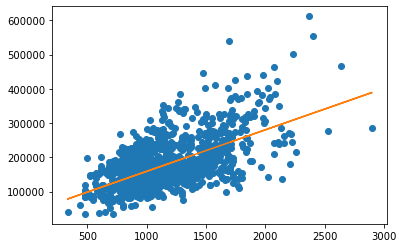

In [12]:
plt.plot(X,Y,'o')
plt.plot(X,Xa*betas)

Lets check how we did on our test set, both with a graph and numerically. Graphically, we can just plot the regression line again the test data scatter plot. We can evaluate the model numerically but computing the residual sum squared
$$
RSS(\beta) = \sum_{i=1}^N (y_i - x_i^T\beta)^2\,,
$$
the root mean square
$$
RMS(\beta) = \left(\frac{1}{N}(y_i - x_i^T\beta)^2\right)^{\frac12}\,,
$$
and the $r^2$ value
$$
r^2 = 1 - \frac{RSS(\beta)}{\sum_{i=1}^N (y_i - E[y])^2}\,.
$$

On the training data, the RMS is

In [13]:
RSS = (Y - Xa*betas).T*(Y - Xa*betas)
RMS = np.sqrt(RSS/len(Y))

print("The Residual Sum Square is", RSS)
print("The Root Mean Square is", RMS)

The Residual Sum Square is [[3.66855699e+12]]
The Root Mean Square is [[56260.80181024]]


Lets set up the matrices for the test data.

In [14]:
XT = np.matrix(X_test['1stFlrSF']).reshape(-1,1)
XTa = np.append(np.ones(XT.shape), XT,1)

YT = np.matrix(Y_test).reshape(-1,1)

We can now compute the RSS and RMS on the test data:

In [15]:
RSS = (YT - XTa*betas).T*(YT - XTa*betas)
RMS = np.sqrt(RSS/len(YT))
print("The Residual Sum Square is", RSS)
print("The Root Mean Square is", RMS)

Rsq = 1 - RSS/((YT - YT.mean()).T*(YT - YT.mean()))

print("R^2 Score is", Rsq)

The Residual Sum Square is [[9.93336699e+11]]
The Root Mean Square is [[59883.66275693]]
R^2 Score is [[0.31837491]]


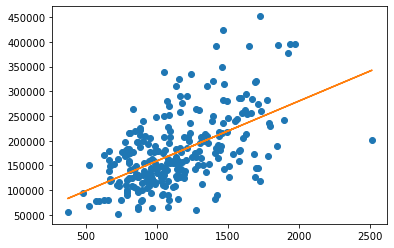

In [16]:
plt.plot(XT,YT,'o')
plt.plot(XT,XTa*betas)

#### Exercise: 

We could also consider other metrics, even when evaluating our result. For example, calculate the __average absolute difference__ between the predicted value and true value for both the test and train data.

In [18]:
np.abs(Y - Xa*betas).mean()

43155.33653442277

In [19]:
np.abs(YT - XTa*betas).mean()

46207.68075589981

#### How do we understand the results

Comparing the RMS values for the train and test data you may find that the results on the training data are better, or that the results on the test data are better. This means that our training data is reasonably representative of the whole set, but you should note that different choices of random splitting in the data will lead to different $\beta$ values and so different goodnesses of fit. This variability with respect to the sampling of the distribution is what is being captured in the variance. 


#### Exercise: 
Try running the code about for two different seeds in the training test split: `random_state=150` and `random_state=200`. Compare the results. How do you explain them?

## Linear Regression with Sklearn

We will now use sci-kit learn's built in regression function. We import `LinearRegression` from `sklearn.linear_model`, the toolkit of linear models in sci-kit learn. We then set up a linear regression object using

`lr = LinearRegression()`

An object like a linear regression object is a structure like a dataframe. It stores data, but also has a series of utility function associated with it. It is a self contained machine that we can put data into, turn a crank (by calling functions) and have it process and return that data. In this case, it takes in training data and fits a linear regressor to it. We can then ask it return the parameters of that regressor with 

* `lr.coef_` Returns the slope coefficients of regression $\beta_1,\ldots, \beta_p$.
* `lr.intercept_` Returns the intercept of regression $\beta_0$.
* `lr.score(X_data,Y_data)` Returns the $r^2$ score on `X_data` and `Y_data`.

Note, that `LinearRegression` wants the data in the form we've been using in class: the $X$ data should be a $N$ by $p$ matrix of data points and the $y$ data should be a $N$ by 1 column vector. 

In [20]:
## Resample the data if needed

train=data.sample(n=Test_Size,replace=False,random_state=150)
test=data.drop(train.index)

X_train = train.drop(columns=['SalePrice','Id'])
Y_train = train['SalePrice']

X_test = test.drop(columns=['SalePrice','Id'])
Y_test = test['SalePrice']

X = np.matrix(X_train['1stFlrSF']).T
Y = np.matrix(Y_train).T

XT = np.matrix(X_test['1stFlrSF']).T
YT = np.matrix(Y_test).T

print('X shape:', X.shape,'Y shape', Y.shape)

X shape: (1159, 1) Y shape (1159, 1)


Note in the above that since Sci-kit learn expects a $N\times p$ matrix for `X` and a column vector for `Y`, we will need to transpose them from their cut form. 

In [21]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X,Y)

print([lr.coef_,lr.intercept_])
print(lr.score(XT,YT))

[array([[121.15764005]]), array([38036.50720916])]
0.3183749093889888


## Regression with statsmodels.api

Although in this class we will be focusing on sci-kit learn, there's another important statistics library to be aware of, statsmodels.api. For regression in particular, statsmodels.api is just a much better tool, performing all of the statistical analysis you would like. The only caveat is that stats model doesn't naturally fit to a constant term, so we must again add a column of 1's. But statsmodels.api has a function to preform that task.

* `sm.OLS(Y_Data, X_data)` OLS returns an ordinary least squares object which can then be fit with `ols.fit()`. The fit object returned by `ols.fit()` has a robust `.summary()` method that gives all us rich and detailed information about the regression fit.

Note: in addition to fitting, OLS has functions to deal with missing values and built in ridge and lasso regression functions. 

In [22]:
import statsmodels.api as sm

ols = sm.OLS(Y, Xa)
ols_result = ols.fit()

ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     715.1
Date:                Thu, 14 Oct 2021   Prob (F-statistic):          4.78e-123
Time:                        20:58:19   Log-Likelihood:                -14321.
No. Observations:                1159   AIC:                         2.865e+04
Df Residuals:                    1157   BIC:                         2.866e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.804e+04   5469.324      6.955      0.000    2.73e+04    4.88e+04
x1           121.1576      4.531     26.741      0.000     112.268     130.047
==============================================================================
Omnibus:                      171.875   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              324.780
Skew:                           0.903   Prob(JB):                     2.98e-71
Kurtosis:                       4.862   Cond. No.                     3.99e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.99e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Note the OLS has also computed the standard error, the $t/z$-statistic and the $95%$ confidence interval.

## Multilinear Regression: Cleaning Data

It actually often takes less computational time to compute a linear regression than it does to plot it. We want to fit the set of training data with all the numerical features to the sale price, but before we do we have to deal with those `NaN` values. For example, if we just try to compute the linear regression now it will return an error. 

Now, lets try to train against all of `X_train` and `Y_train` using sci-kit learn.

In [23]:
lr = LinearRegression()
lr.fit(X_train,Y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Fixing missing values is fiddly, and should be done with care. Whatever choice you make will effect your fit, and as a result will effect your accuracy. In general, data cleaning is the usually more than half the battle. 

To find the `NaN` values, we will use the `DataFrame.isnull().sum()` to return all of the null values, and them sum them along columns. 

In [24]:
data.isnull().sum()

Id                 0
LotFrontage      258
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       79
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SalePrice          0
dtype: int64

We find that __LotFrontage__, __MasVnrArea__, and __GarageYrBlt__ are the only numerical features with null values. Lets take a look at each of these values individually. After we make a choice for each variable, we will use

* `DataFrame.fillna(Value, inplace=True)` fills all of the `NaN` values in an array with the contents of `Value`. 

__MasVnrArea__ is "Masonry veneer area in square feet". Dumping the data we find a lot of zero values, so its probably safe to assume that 8 values can be set to 0 or the median value. 

In [25]:
data["MasVnrArea"].fillna(0,inplace=True)
data.MasVnrArea.isnull().sum()

0

For __GarageYrBlt__, a value of `NaN` probably means there's no garage. Lets check just to make sure by looking at the __GarageArea__ variable for every `NaN` value.

In [26]:
sum(data["GarageArea"][data["GarageYrBlt"].isnull()])

0

In [27]:
data["GarageYrBlt"].fillna(0,inplace=True)

Finally, for __LotFrontage__ we assume that almost every lot has some frontage road so we don't want to set this to 0. There are more sophisticated solutions, but the simplest is just to find the median value and set the null values to it. 

In [28]:
m = np.median((data["LotFrontage"][data["LotFrontage"].notnull()]))

data["LotFrontage"].fillna(m, inplace=True)
data.MasVnrArea.isnull().sum()

0

Finally, lets check to make sure we've elemented all missing values.

In [29]:
data.isnull().sum().sum()

0

### Cross validation and Fitting
We now reestablish our train/test split

In [30]:
Test_Size = 1000

train=data.sample(n=Test_Size,replace=False)
test=data.drop(train.index)

print("Train Shape", train.shape)
print("Test Shape", test.shape)

X_train = train.drop(columns=['SalePrice','Id'])
Y_train = train['SalePrice']

X_test = test.drop(columns=['SalePrice','Id'])
Y_test = test['SalePrice']

Train Shape (1000, 37)
Test Shape (436, 37)


And train the data using statsmodels.api. Remember that we have to add a column to `X_train` to account for the constant term. Luckly, statsmodels has built in function for that `sm.add_constant(X_data)`

In [31]:
ols = sm.OLS(Y_train, sm.add_constant(X_train))
ols_result = ols.fit()

ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     207.2
Date:                Thu, 14 Oct 2021   Prob (F-statistic):               0.00
Time:                        21:01:39   Log-Likelihood:                -11580.
No. Observations:                1000   AIC:                         2.323e+04
Df Residuals:                     966   BIC:                         2.339e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.171e+05   1.29e+06      0.091      0.928   -2.41e+06    2.65e+06
LotFrontage     179.4069     46.860      3.829      0.000      87.448     271.366
LotArea           0.5208      0.081      6.463      0.000       0.363       0.679
OverallQual    1.299e+04   1080.660     12.021      0.000    1.09e+04    1.51e+04
OverallCond    6101.5267    916.318      6.659      0.000    4303.324    7899.729
YearBuilt       419.6704     54.806      7.657      0.000     312.119     527.222
YearRemodAdd    161.4760     60.410      2.673      0.008      42.926     280.026
MasVnrArea       20.8042      5.670      3.669      0.000       9.677      31.931
BsmtFinSF1       24.0507      2.414      9.962      0.000      19.313      28.789
BsmtFinSF2        0.9682      4.180      0.232      0.817      -7.235       9.171
BsmtUnfSF        -0.5158      2.224     -0.232      0.817      -4.880       3.848
TotalBsmtSF      24.5030      3.135      7.816      0.000      18.351      30.655
1stFlrSF         23.4604      5.696      4.119      0.000      12.283      34.637
2ndFlrSF         27.4481      5.326      5.153      0.000      16.996      37.901
LowQualFinSF    -27.5512     14.116     -1.952      0.051     -55.252       0.150
GrLivArea        23.3572      5.505      4.243      0.000      12.554      34.161
BsmtFullBath   -400.7190   2403.439     -0.167      0.868   -5117.283    4315.845
BsmtHalfBath  -9659.6909   3834.624     -2.519      0.012   -1.72e+04   -2134.538
FullBath      -2561.8343   2555.539     -1.002      0.316   -7576.881    2453.213
HalfBath      -2342.3383   2541.504     -0.922      0.357   -7329.843    2645.166
BedroomAbvGr  -1.153e+04   1607.479     -7.174      0.000   -1.47e+04   -8377.624
KitchenAbvGr  -2.093e+04   4707.831     -4.445      0.000   -3.02e+04   -1.17e+04
TotRmsAbvGrd   6144.0038   1130.866      5.433      0.000    3924.766    8363.241
Fireplaces     1137.4930   1636.879      0.695      0.487   -2074.755    4349.741
GarageYrBlt     -12.3855      2.392     -5.178      0.000     -17.080      -7.691
GarageCars     9852.0644   2912.001      3.383      0.001    4137.488    1.56e+04
GarageArea       19.1906      9.888      1.941      0.053      -0.215      38.596
WoodDeckSF       14.0618      7.274      1.933      0.054      -0.213      28.336
OpenPorchSF      17.8079     14.549      1.224      0.221     -10.742      46.358
EnclosedPorch    17.8504     15.963      1.118      0.264     -13.476      49.177
3SsnPorch        -2.9378     31.005     -0.095      0.925     -63.782      57.906
ScreenPorch      36.3812     18.398      1.977      0.048       0.277      72.486
PoolArea          7.3032     23.210      0.315      0.753     -38.244      52.850
MiscVal          -3.2070      2.636     -1.217      0.224      -8.380       1.966
MoSold           93.4780    323.845      0.289   

Now we want to score this model on test data. Unfortunently statsmodels.api doesn't have a built in test function, but we can use our own pretty easily. 

In [32]:
def RSS(y,Y):
    y = np.matrix(y).reshape(-1,1)
    Y = np.matrix(Y).reshape(-1,1)
    
    return (y-Y).T*(y-Y)

def RMS(y,Y):    
    return np.sqrt(RSS(y,Y))/len(y)

def Rs(y,Y): 
    y = np.matrix(y).reshape(-1,1)
    Y = np.matrix(Y).reshape(-1,1)
    
    return 1 - RSS(y,Y)/((Y - np.mean(Y)).T*(Y - Y.mean()))

In [33]:
pred = ols_result.predict(sm.add_constant(X_test))
Rs(pred, Y_test)
#RMS(pred, Y_test)

matrix([[0.85705778]])

## Ridge Regression and Lasso Regression

Now that we have a baseline, we try out our new methods. We will look at ridge regression and lasso regression first, since they implemented in OLS. 

A `statsmodel.api.ols` object has a regularized regression fit function `ols.fit_regualrized()` that implements both lasso and ridge regression. In fact, it minimizes the loss function

$$
\textbf{Loss}(\beta) = \frac{1}{2n}\textbf{RSS} + \alpha\left(\frac{(1-\lambda)}{2}\sum_i \beta_i^2 + \lambda\sum_i|\beta_i|\right)
$$

In ridge regression, $\lambda = 0$ and so we are minimizing $RSS(\beta)$ subject to the additional constrain that $||\beta||^2$ is small. For a fixed value of the constraint $||\beta||^2 = R$, the $\beta$'s are constrained to a sphere. 

The addition of the lasso regression condition leads to a non-smoothness around the axes for the $\beta$ constraint. These two terms are both examples of __regulators__, and will be discussed more in class. 


This linear combination of loss functions is known as __elastic net regression__. For a little demo of the interpolation between the bounded regions for the variables take a look at this Desmos applet: The applet shows how the shape of the possible $\beta_i$ change for a fixed value of the regulator given different $\lambda$ and $\alpha$.  In the demo, $a$ is the $\alpha$ variable and $b$ is the $\lambda$ variable. 

https://www.desmos.com/calculator/a4a6qgitr7


The `ols.fit_regualrized()` takes the following form, where $\lambda$ is `L1_wt`:

* `OLS.fit_regularized(alpha=0.0, L1_wt=1.0, start_params=None)` Here, `alpha` is the overall weight $\alpha$ and `L1_wt` is the coefficient of the $L_1$ norm. 

## Ridge Regression

First, lets compute the ridge regression. Note that not all of the functionality has been added to statsmodels.api's OLS class yet. In particular, summary doesn't work. But we can still compute $r^2$ values on the test set using the functions we defined above. Pick a value at random, let's compute with 

In [34]:
ols = sm.OLS(Y_train, sm.add_constant(X_train))
ols_result = ols.fit_regularized(L1_wt=0,alpha=1)

Rs(ols_result.predict(sm.add_constant(X_test)),Y_test)

matrix([[0.82625531]])

We're probably already doing worse than expected. Lets predict for 50 $\alpha$ values from 0 to 1. We will save the $r^2$ value in in a list, by creating an empty list and appending each value into it. 

In [35]:
r_sqds = []
alphas = np.linspace(0,.1,50)

for alp in alphas:
    ols = sm.OLS(Y_train, sm.add_constant(X_train))
    ols_result = ols.fit_regularized(L1_wt=0,alpha=alp)

    r_sqds.append(Rs(ols_result.predict(sm.add_constant(X_test)),Y_test).A1)

0.8570850292868071


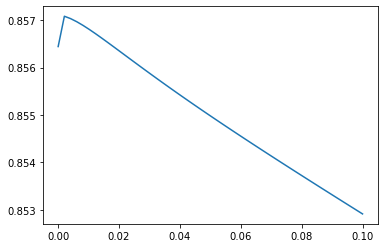

In [36]:
print(np.max(r_sqds))
plt.plot(alphas, r_sqds)

If we add a few lines of code to save the $\hat \beta$ values at each iteration, you can plot them again each other. Of course, the vast difference in $\hat \beta$ values we saw in the ordinary linear regression model indicates that they wont be very meaningful on the same graph (the largest are on the order of $10^6$, the smallest on the order of $10^{-1}$). 

The simplest way to overcome this, if we are just intersted in the dynmics of the varaibles, is to normalize the largest $|\beta_i^{\alpha}|$ to 1 for each feature. This can be done by dividing by the max of the absolute value. 

In [42]:
r_sqds = []
betas = pd.DataFrame(columns=["Coeff"]+list(X_train))
alphas = np.linspace(0,.1,50)

for alp in alphas:
    ols = sm.OLS(Y_train, sm.add_constant(X_train))
    ols_result = ols.fit_regularized(L1_wt=0,alpha=alp)

    r_sqds.append(Rs(ols_result.predict(sm.add_constant(X_test)),Y_test).A1)
    beta = pd.DataFrame(ols_result.params.reshape(1,-1),columns=["Coeff"]+list(X_train))
    betas = betas.append(beta)

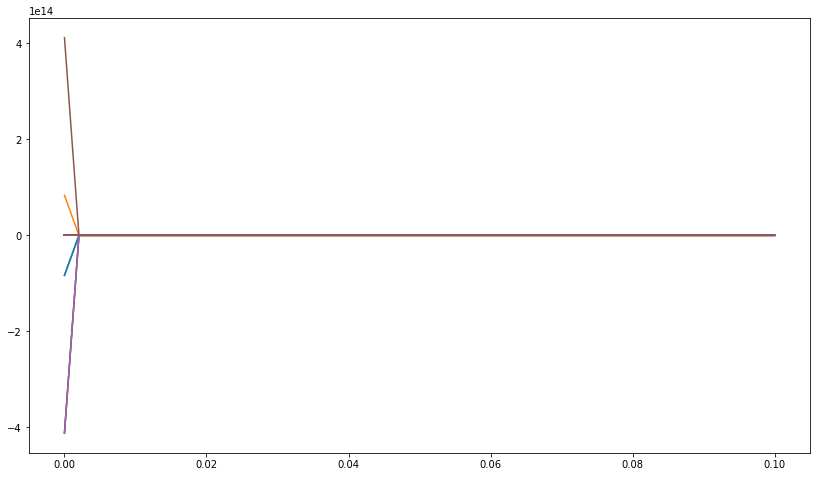

In [43]:
f, axes = plt.subplots()
f.set_size_inches(14,8)
plt.plot(alphas,betas)
 

AttributeError: 'matrix' object has no attribute 'abs'

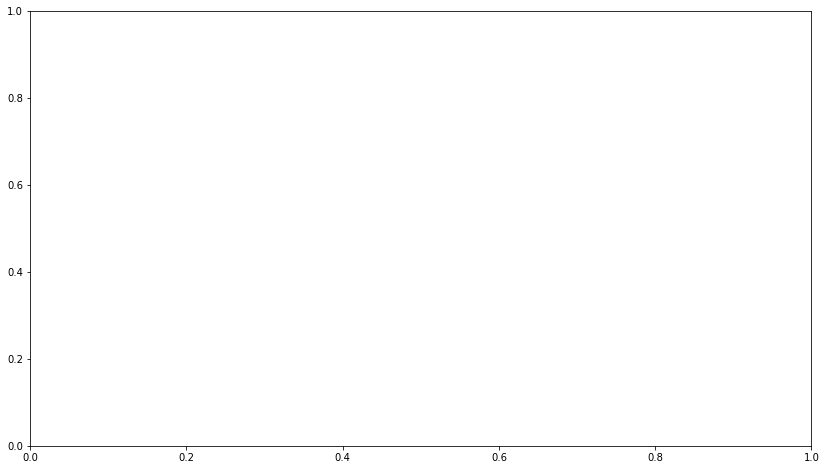

In [38]:
f, axes = plt.subplots()
f.set_size_inches(14,8)

plt.plot(alphas,betas/betas.abs().max())
plt.legend(["Coeff"]+list(X_train))

## Lasso Regression

To compute the Lasso regression we can recycle our code from above, but now we set `L1_wt=1`, turning off the ridge parameters and turning of the Lasso. We will also have to modify our $alpha$ values since the $\beta$ are penalized much less for being large. 

In [39]:
r_sqds = []
rss_s = []
betas = pd.DataFrame(columns=["Coeff"]+list(X_train))
alphas = np.linspace(600,1200,20)

for alp in alphas:
    ols = sm.OLS(Y_train, sm.add_constant(X_train))
    ols_result = ols.fit_regularized(L1_wt=1,alpha=alp)

    r_sqds.append(Rs(ols_result.predict(sm.add_constant(X_test)),Y_test).A1)
    rss_s.append(RMS(ols_result.predict(sm.add_constant(X_test)),Y_test).A1)
    beta = pd.DataFrame(np.array(ols_result.params).reshape(1,-1),columns=["Coeff"]+list(X_train))
    betas = betas.append(beta)

In [40]:
X_train

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
620,45.0,8248,3,3,1914,1950,0.0,41,0,823,...,0,0,0,100,0,0,0,0,9,2008
68,47.0,4608,4,6,1945,1950,0.0,0,0,747,...,220,0,0,0,0,0,0,0,6,2010
330,69.0,10624,5,4,1964,1964,84.0,40,264,1424,...,352,155,0,0,0,0,0,0,11,2007
1237,41.0,12393,7,5,2004,2005,0.0,0,0,847,...,434,100,48,0,0,0,0,0,9,2006
498,65.0,7800,5,7,1967,2004,89.0,450,0,414,...,288,64,0,0,0,0,0,0,6,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,21.0,1680,6,5,1972,1972,297.0,0,0,483,...,288,0,0,0,0,0,0,0,6,2006
0,65.0,8450,7,5,2003,2003,196.0,706,0,150,...,548,0,61,0,0,0,0,0,2,2008
374,65.0,8200,7,5,2003,2004,0.0,0,0,847,...,434,100,48,0,0,0,0,0,7,2007
634,64.0,6979,6,5,1980,1980,0.0,1056,0,0,...,576,264,56,0,0,0,0,600,6,2010


In [41]:
betas = pd.DataFrame(columns=["Coeff"]+list(X_train))
betas

,Coeff,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold


0.8425996566585093
1298.7319684771953


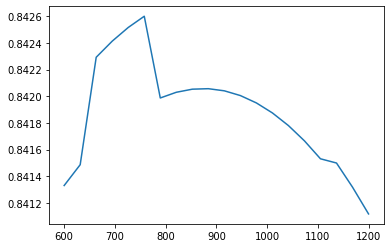

In [46]:
print(np.max(r_sqds))
print(np.max(rss_s))
plt.plot(alphas, r_sqds)

ValueError: x and y must have same first dimension, but have shapes (20,) and (0, 36)

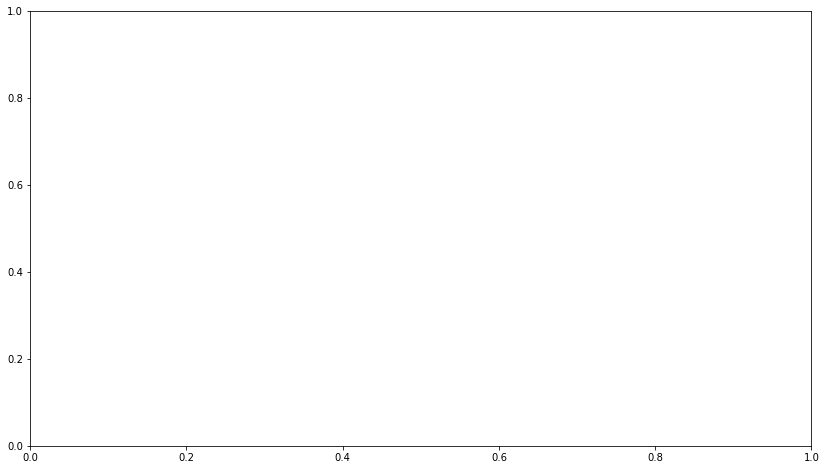

In [42]:
f, axes = plt.subplots()
f.set_size_inches(14,8)

plt.plot(alphas,betas/betas.abs().max())
plt.legend(["Coeff"]+list(X_train))

# Subset Selection:

We will implement subset selection algorithms. Before we could lean on built in libraries, but we will now have to implement the algorithms ourself. Luckily, subset selection is a relatively straight forward idea. 

## Forward subset selection:

We will begin with forward subset selection using the $r^2$ value. The idea is to greedily add variables to our fitting, starting with the best single variable predictor and adding new variables one at a time. 

We will implement a function that returns the best predictor to add to a list of preselected predictors. This function will take the form

* `best_predict(inc, X_train, Y_train)` Return the single feature which improves the $r^2$ score the most. Here, `inc` is a list of predictors that we have already included.

Our `best_predict` function will be laid out as follows:

* First, get a list of columns in `X_train` that are no in already in `inc`.
* Set up lists to hold the column names, and the $r^2$ value of the model after adding each new column.
* Loop of the features found in the first step. For each feature `p`:
* * Fit a linear model to the features in `inc` and the feature `p`.
* * Score the model on the test data.
* * Append the feature name to the Columns list and append the computed $r^2$ value to the list of $r^2$ values. 
* After running the loop above, we get the index of the maximum $r^2$ value computed above. This will correspond to the list of features with the biggest improvement. 
* Return the maximum $r^2$ value, along with the list of features. 

We can then call this function iteratively, feeding the input of the previous run into the next run. 

In [48]:
def best_predict(inc, X_train, Y_train, X_test,Y_test):
    rem_pred = [p for p in X_train.columns if p not in inc]
    
    RSquared = []
    Columns = []
    
    for p in rem_pred:
        olst = sm.OLS(Y_train, sm.add_constant(X_train[inc+[p]]))
        olst_result = olst.fit()    
        
        R_sq = Rs(olst_result.predict(sm.add_constant(X_test[inc+[p]])),Y_test)
        
        RSquared.append(R_sq)
        Columns.append(inc+[p])
        
    z = RSquared.index(max(RSquared))
    print("Maximum r^2", RSquared[z])
    print("Columns", Columns[z])
    
    return([float(RSquared[z]),Columns[z]])

Maximum r^2 [[0.60838643]]
Columns ['OverallQual']
Maximum r^2 [[0.72414487]]
Columns ['OverallQual', 'GrLivArea']
Maximum r^2 [[0.78804998]]
Columns ['OverallQual', 'GrLivArea', 'TotalBsmtSF']
Maximum r^2 [[0.80614899]]
Columns ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars']
Maximum r^2 [[0.82008534]]
Columns ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', 'BsmtUnfSF']
Maximum r^2 [[0.82876999]]
Columns ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', 'BsmtUnfSF', 'KitchenAbvGr']
Maximum r^2 [[0.83629428]]
Columns ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', 'BsmtUnfSF', 'KitchenAbvGr', 'LotArea']
Maximum r^2 [[0.84289725]]
Columns ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', 'BsmtUnfSF', 'KitchenAbvGr', 'LotArea', 'YearRemodAdd']
Maximum r^2 [[0.84639626]]
Columns ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', 'BsmtUnfSF', 'KitchenAbvGr', 'LotArea', 'YearRemodAdd', 'BedroomAbvGr']
Maximum r^2 [[0.84993469]]
Columns ['O

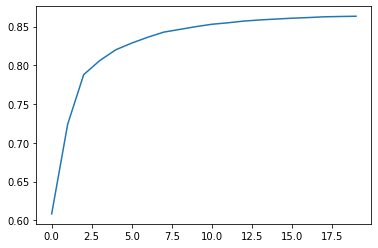

In [49]:
varlist = []
r_list = []

for i in range(0,20):
    r,varlist = best_predict(varlist,X_train, Y_train, X_test, Y_test)
    r_list = r_list + [r]
    
plt.plot(r_list)

## (Extra) Best subset selection and residual bootstrapping:

Best subset selection is impractical on large arrays of variables, but it's good to understand how it can be implemented. The code below uses itertools to iterate over all subsets of the range. Notice though that even for subsets of size 3 it really begins to chugg. This naive version of best subset selection shouldn't be used for data sets with this many features. 

In [53]:
r_list

[0.608386430683607,
 0.7241448715281513,
 0.7880499765464252,
 0.8061489909580029,
 0.8200853389238623,
 0.8287699854146274,
 0.8362942827376637,
 0.842897249986106,
 0.846396262167995,
 0.8499346883811532,
 0.8530359291573579,
 0.8549036100611298,
 0.8571641612611197,
 0.8586009577856409,
 0.8597504933362459,
 0.8608397333744321,
 0.8616526250632547,
 0.8626291094535105,
 0.8630523876640158,
 0.8633741636789622]

In [54]:
import itertools
p = len(list(X_train)) # Number of featuers

names = list(X_train)

for d in range(1,3):

    subsets = list(itertools.combinations(range(0,p), d))
    print(p, "features,", len(subsets),"subsets of length ", d)

    fits = pd.DataFrame(columns=['cols','r sq train','r sq test','parameters'])

    for s in subsets:
        si = [names[i] for i in s]

        lr = LinearRegression()
        lr.fit(X_train[si],Y_train)

        Y_head_lr = lr.predict(X_test[si])
        rtr = Rs(Y_head_lr,Y_test)

        Y_head_lr_train = lr.predict(X_train[si])
        rte = Rs(Y_head_lr_train,Y_train)

        fits = fits.append({'cols':s,'r sq train':rtr,'r sq test':rte,'parameters':lr.coef_},ignore_index=True)
    
    best = fits.sort_values("r sq test",ascending=False).head(1)
    print(best[['cols','r sq train','r sq test']])
    print(best['parameters'])
    print()

35 features, 35 subsets of length  1
   cols            r sq train             r sq test
2  (2,)  [[[[[0.60838643]]]]]  [[[[[0.64433449]]]]]
2    [43381.30590267366]
Name: parameters, dtype: object

35 features, 595 subsets of length  2
       cols            r sq train             r sq test
78  (2, 14)  [[[[[0.72414487]]]]]  [[[[[0.72604382]]]]]
78    [32835.83187836154, 53.19137363311746]
Name: parameters, dtype: object



## Exercise:

Find the best single varaible to drop from the full linear linear fit. That is, do one step of backwards subset selection. 

## Exercise:

Keeping in mind that the training/test split was arbitrary, what do you expecct the best method for prediction on the Ames data set to be? Justify your answer. 

## Exercise:

The `ols.fit_regularized(L1_wt=1,alpha=alp)` function alloes us to use eleastic net regression allow us to mix the ridge and lasso methods.

Splitting the data using 

`train=data.sample(n=Test_Size,replace=False, random_state=200)`

where the `random state` seed has been set to 200 will help normalized the results. What is the best pair $(\alpha,\lambda)$ to fit with?

## (Extra) Degrees of Freedom

As we construct our various linear models, we want to compare them based on their degrees of freedom. Recall that the number of degrees of freedom of a model $\hat h:\mathcal{X}\to \mathcal{Y}$ with $\hat y_i = h(\hat x_i)$ is 
$$
df(\hat f) = \frac{1}{\sigma^2} \sum_{i=1}^N \text{Cov}(\hat y_i,y_i) = \frac{1}{\sigma^2}\text{Tr}\big(\text{Cov}(\hat y,y)\big)
$$
where the variance can be estimated by 
$$
\frac{1}{N-p-1}\sum_{i=1}^N (\hat y_i-y_i)^2
$$
To estimate the covariance, we will use a method called __residual bootstraping__. The idea is to estimate the covariance by creating a discrete distribution $\mathcal{R}$ of the residual errors 
$$
\mathcal{R}=\{\hat e_i = y_i-\hat y_i\}\,,
$$
and repeatedly sampling it to estimate the covariance. Here, the hat on $\hat e$ just indicates that this is dependent on the model fit $\hat f$. 

The algorithm is:

<div class="alert alert-block alert-success">
<b>Residual bootstraping</b><br>

<ul>
    <li>For $i=1,...,N$ create a new set of bootstrap samples $\hat b_{i} = \hat y_i + e$ where $e$ is drawn uniformly from the distribution of residuals $\mathcal{R}$.</li>
    <li>Recompute the fit $h^{(b)}$ on the samples $(x_i, b_i)$, and use the new sample data to compute $\text{Cov}(b_i,y_i)$</li>
    
</ul>
</div>

## Problems uploaded in a later file.